---
**Dataset:** *Coral reef global bleaching*


**Objective:** *Predict reef bleaching*

**Author:** *Danylo Zemskyi, Omari March*

**Date:** *15/12/2025*

---

## 1. Introduction

### 1.1 Problem Statement

* Description of the task: Bleaching prediction for Coral Reef Global Bleaching dataset (Population/Colony wide).
* Target variable: This problem is about predicting how much coral bleaching occurs (measured as Percent Bleaching) based on environmental and physical factors like water depth, temperature, distance from shore, exposure, turbidity, and cyclone frequency (Regression problem).
* Topic relevance: Coral reefs play a vital role in marine ecosystem health. Coral reefs are able to support diverse ecosystems, filter the water, and create oxygen when they have clean, clear, and cool water to support them. Also, they protect shorelines by reducing the impact from waves, storms, and floods. This helps prevent loss of life, property damage, and erosion. When reefs are damaged or destroyed, coastal communities can suffer increased damage from severe storms, and even normal wave action. Bleached corals continue to live, but they are more vulnerable to disease and starvation.

### 1.2 Dataset Overview

* Source of the dataset: https://www.kaggle.com/datasets/mehrdat/coral-reef-global-bleaching
* Number of samples and features: The dataset consists of 2 csv files, which have 18 and 62 Features, and 41361 rows each. Csv file with 62 features provides a lot of redundant metrics that can be derived with formulas. Both files can be merged by Sample_ID column
* Feature types (numerical, categorical, target)


## 2. Experimental Setup

### 2.1 Libraries

Used libs
numpy
pandas

matplotlib
seaborn
os

sklearn
statsmodels
scipy

xgboost
tensorflow.keras

### 2.2 Evaluation Metrics

* Metrics used: R2 and MAE
* Justification: MAE is preferred in tasks involving skewed or outlier-prone data because it provides a robust, scale-consistent measure of average model error without disproportionately penalizing large deviations.
	As the baseline model mean predictor was chosen, which can give a sense what is the minimal mean absolute error model has to archive to be better than a simple mean model (MAEbaseline = 11.29).
	R2 provides an interpretable measure of overall model fit and how well the model captures data patterns relative to a naive mean-based predictor, which is picked as baseline performance.

### 2.3 Dataset split

* Split method used: train-test split(TTS)
* TTS chosen over k-fold cross-validation as the dataset is sufficiently large to minimize overfitting risks associated with TTS, while significantly reducing computational cost by requiring only a single model training instead of multiple iterations.




In [133]:

"""Data manipulations libs"""
import numpy as np
import pandas as pd

"""Plotting libs"""
import matplotlib.pyplot as plt
import seaborn as sns
import os

"""Models evaluations imports"""
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

"""Data preprocessing imports"""
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew, boxcox


"""Dataset stats imports"""
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor

"""Models that were used imports"""
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, Dropout, ReLU, Add
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout

## 3. Baseline Model


### 3.1 Baseline Definition

Since this the task involves regression for Percent_Bleaching prediction, the baseline performance can be assessed using simple models such as the mean predictor or median predictor, which always predict the average or median bleaching percentage across the dataset. That will provide us with a reference level of performance to compare more complex models against.

### 3.2 Baseline Results


In [134]:
path = "./coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df = pd.read_csv(filename_read)

df  = df.drop(columns=['Sample_ID', 'Percent_Cover', 'Date_Year']) #Percent_Cover has 30% of its row NA, so it significantly cuts dataset
df.dropna(inplace=True)


df.info()
print(df)

<class 'pandas.core.frame.DataFrame'>
Index: 32714 entries, 0 to 35044
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cyclone_Frequency    32714 non-null  float64
 1   Depth_m              32714 non-null  float64
 2   ClimSST              32714 non-null  float64
 3   Ocean_Name           32714 non-null  object 
 4   Country_Name         32714 non-null  object 
 5   Distance_to_Shore    32714 non-null  float64
 6   Exposure             32714 non-null  object 
 7   Turbidity            32714 non-null  float64
 8   Bleaching_Level      32714 non-null  object 
 9   Temperature_Maximum  32714 non-null  float64
 10  SSTA                 32714 non-null  float64
 11  TSA                  32714 non-null  float64
 12  Percent_Bleaching    32714 non-null  float64
 13  Temperature_Mean     32714 non-null  float64
 14  Realm_Name           32714 non-null  object 
dtypes: float64(10), object(5)
memory usage: 4

In [135]:
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = [col for col in df.columns if col not in num_cols]

target_value_col = "Percent_Bleaching"

In [136]:
# Target value
y = df[target_value_col].to_list()

# Mean prediction
y_median = np.median(y)
y_mean = np.mean(y)

y_pred_median = np.full(len(y), y_median)
y_pred_mean = np.full(len(y), y_mean)

# Metrics Median
mae_median = mean_absolute_error(y, y_pred_median)
rmse_median = root_mean_squared_error(y, y_pred_median)
r2_median = r2_score(y, y_pred_median)

print("Median Baseline Results:")
print(f"MAE: {mae_median:.4f}")
print(f"RMSE: {rmse_median:.4f}")
print(f"R: {r2_median:.4f}")

# Metrics Mean
mae_mean = mean_absolute_error(y, y_pred_mean)
rmse_mean = root_mean_squared_error(y, y_pred_mean)
r2_mean = r2_score(y, y_pred_mean)

print("\nMean Baseline Results:")
print(f"MAE: {mae_mean:.4f}")
print(f"RMSE: {rmse_mean:.4f}")
print(f"R: {r2_mean:.4f}")



Median Baseline Results:
MAE: 8.0678
RMSE: 19.8756
R: -0.1973

Mean Baseline Results:
MAE: 11.2953
RMSE: 18.1646
R: 0.0000


## 4. Exploratory Data Analysis (EDA)

### 4.1 Target Distribution

Histogram shows that target value has a lot of outliers and extremely skewed around 0%, which implies that Percent_Bleaching values has to be scaled to mitigate impact of imbalance distribution and normalized. Nevertheless, The histogram highlights a fundamental difference between population-level and colony-level bleaching observations. Population-level measurements provide a broad, aggregated indication of overall bleaching severity across reef sites, whereas colony-level observations capture finer-scale variability and extreme responses at the individual colony level. Because these two data types represent different ecological scales and statistical distributions, training a single model on both would conflate distinct processes and potentially bias predictions. Therefore, separate models are required to accurately capture bleaching dynamics at each observational scale.

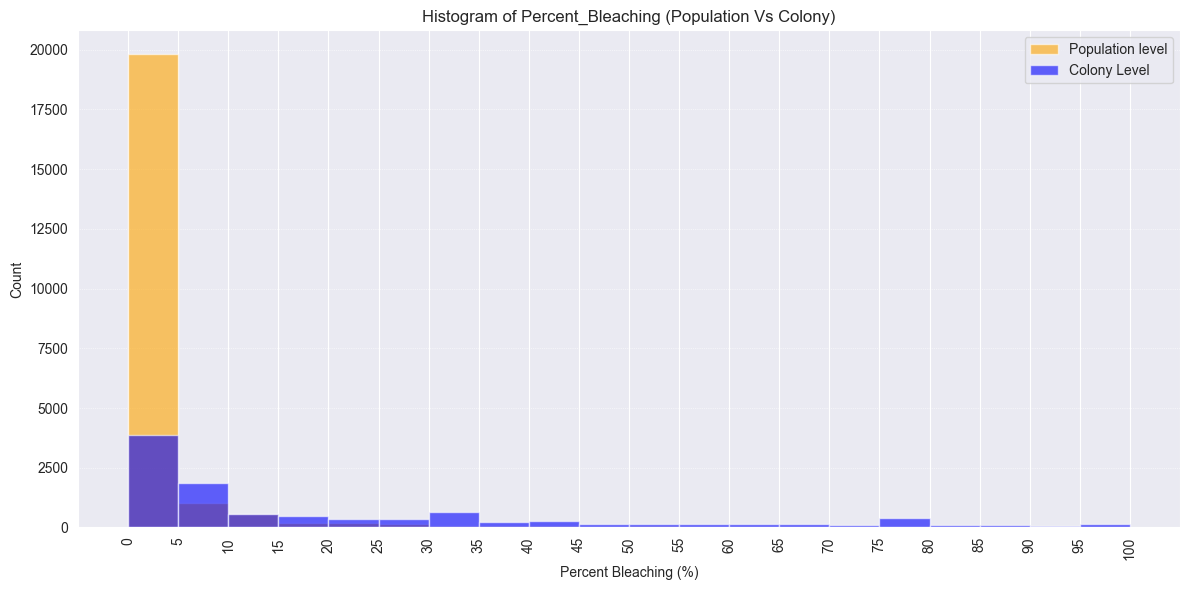

In [137]:
# Create boolean masks to separate samples with and without bleaching

df_population = df[df["Bleaching_Level"] != "Colony"]
df_colony = df[df["Bleaching_Level"] != "Population"]

bins = np.arange(0, 105, 5)  # from 0 to 100 in steps of 0.5

# Generate bin labels (not directly used in plotting)
labels = [f"{b}–{b+5}%" for b in bins[:-1]]

# Plot histogram for no bleaching samples
plt.figure(figsize=(12, 6))
plt.hist(
    df_population[target_value_col],
    bins=bins,
    color="orange",
    alpha=0.6,
    edgecolor=None,
    label="Population level"
)

# Plot histogram for samples with bleaching
plt.hist(
    df_colony[target_value_col],
    bins=bins,
    color="blue",
    alpha=0.6,
    edgecolor=None,
    label="Colony Level"
)
plt.xticks(bins)
plt.xlabel("Percent Bleaching (%)")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Histogram of Percent_Bleaching (Population Vs Colony)")
plt.grid(axis="y", linestyle=":", linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()



### 4.2 Feature Distribution and Skewness

The majority of numerical features in the dataset exhibit pronounced skewness, with several key variables showing strong right-skew (e.g., Distance_to_Shore, Turbidity, Percent_Bleaching) and others displaying left-skewed distributions (e.g., ClimSST, Temperature_Mean, TSA), indicating non-normal feature distributions and further motivating the use of transformation and non-linear modeling approaches.


In [138]:

def get_skewness(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    skewness_results = {}

    # Iterate through numerical columns
    for col in numeric_cols:
        numeric_data = df[col]

          # Compute skewness only if the column contains data
        if len(numeric_data) > 0:
            skew_val = skew(numeric_data)

            # Store skewness value and categorize its type
            skewness_results[col] = {
                'skewness': skew_val,
                'skew_type': 'Right (Positive)' if skew_val > 0.5 else 'Left (Negative)' if skew_val < -0.5 else 'Approximately Symmetric',

            }

    # Convert and sort results to a DataFrame for easier inspection
    skewness_df = pd.DataFrame(skewness_results).T
    skewness_df = skewness_df.sort_values('skewness', key=abs, ascending=False)

    print(skewness_df[:-1])
    return skewness_results


skewness_results = get_skewness(df)

                     skewness         skew_type
Distance_to_Shore    9.390477  Right (Positive)
Turbidity            3.848336  Right (Positive)
Percent_Bleaching    2.969849  Right (Positive)
ClimSST             -1.640544   Left (Negative)
Temperature_Mean    -1.320474   Left (Negative)
Depth_m              1.272371  Right (Positive)
TSA                 -1.013456   Left (Negative)
Temperature_Maximum  0.930379  Right (Positive)
Cyclone_Frequency    0.891588  Right (Positive)


### 4.3 Feature Relationships

The Pearson correlation matrix shows generally weak linear relationships among the environmental variables and between predictors and the target variable (Percent_Bleaching). Most correlation coefficients are close to zero, indicating limited linear dependence.

<Axes: >

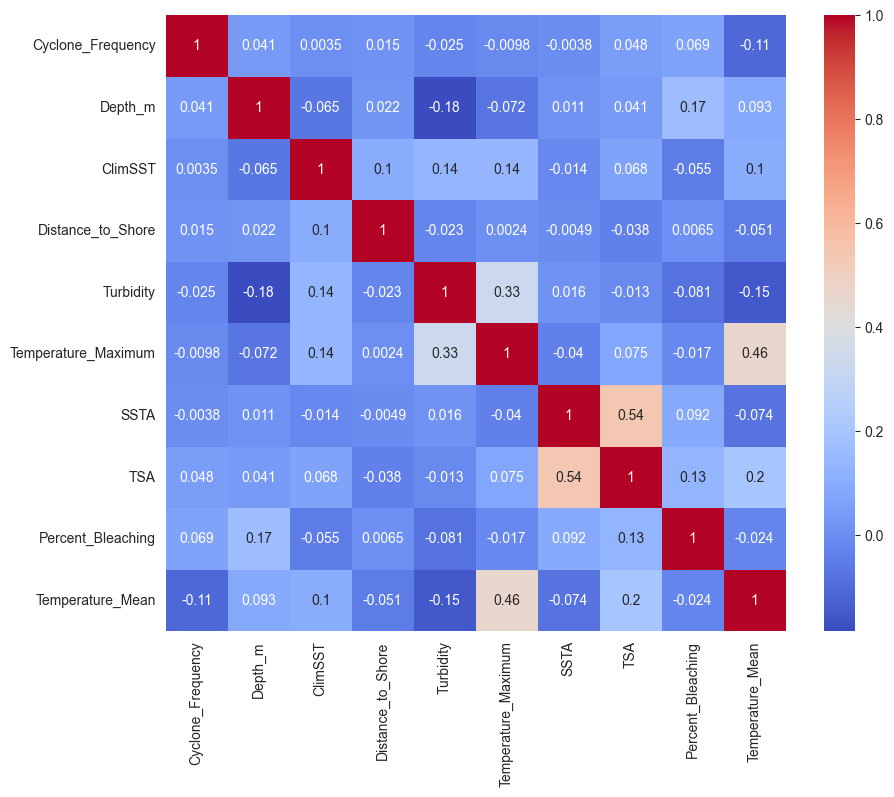

In [139]:

df_numeric = df[num_cols]

pearson_corr_matrix = df_numeric.corr(method="pearson")

features = pearson_corr_matrix.index

# Use Heatmap to visualize matrix
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr_matrix, annot=True, cmap="coolwarm")

The Spearman correlation matrix reveals stronger monotonic relationships than those observed with Pearson correlation, indicating that several variables are related in a non-linear but monotonic manner.

<Axes: >

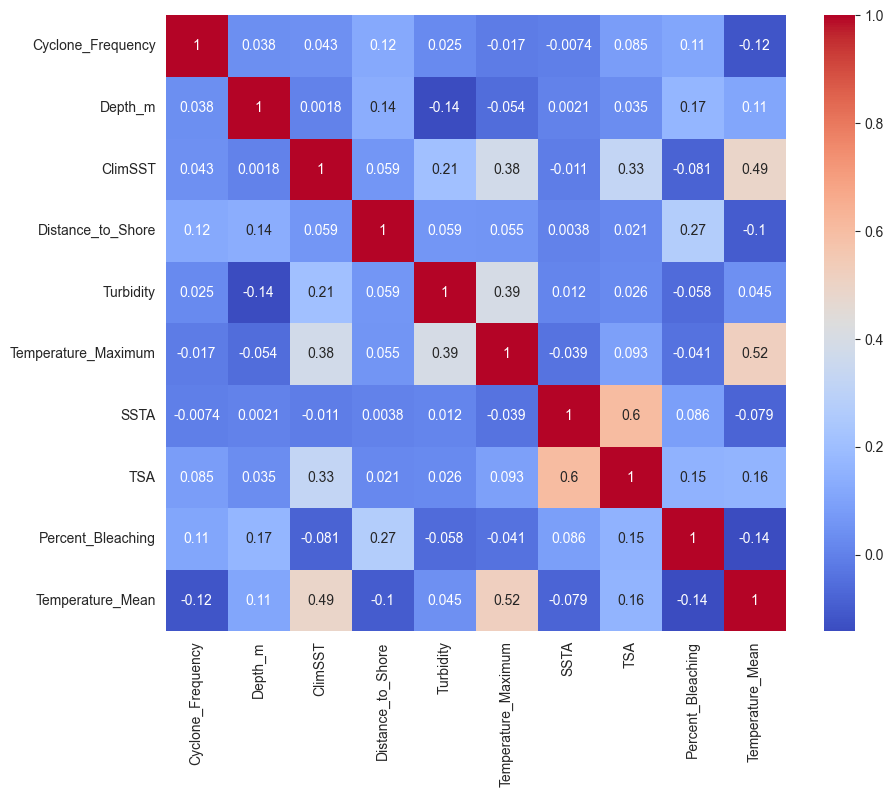

In [140]:
spearman_corr_matrix = df_numeric.corr(method="spearman")
features = spearman_corr_matrix.index

# Use Heatmap to visualize matrix
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap="coolwarm")

The VIF analysis reveals severe multicollinearity among temperature-related variables (Temperature_Mean and ClimSST), confirming strong feature redundancy and motivating the use  non-linear models that are less sensitive to collinearity.

In [141]:
vif_data = pd.DataFrame()

# Add numerical feature names
vif_data["features"] = num_cols

# Compute VIF for each numerical feature by regressing it against all other features
vif_data["vif"] = [
    variance_inflation_factor(df_numeric.values, i)
    for i in range(len(num_cols))
]

vif_data


,features,vif
0,Cyclone_Frequency,51.860955
1,Depth_m,4.060596
2,ClimSST,411.180812
3,Distance_to_Shore,1.109021
4,Turbidity,3.253969
5,Temperature_Maximum,55534.515475
6,SSTA,1.607220
7,TSA,2.062368
8,Percent_Bleaching,1.270236
9,Temperature_Mean,54902.395242


Mutual information regression was used to quantify the non-linear dependency between each numerical feature and the target variable, Percent Bleaching. Unlike correlation-based measures, mutual information captures both linear and non-linear relationships without assuming monotonicity. The results indicate that Distance to Shore, Cyclone Frequency, and temperature-related variables exhibit the strongest non-linear associations with bleaching severity, while Depth shows a comparatively weaker influence. As expected, the target variable itself ranks highest, serving as a validation of the method.


In [142]:
mi_X = df_numeric.drop(target_value_col, axis=1)
mi_X.drop(["Temperature_Maximum", "ClimSST"], axis=1, inplace=True)


## Compute mutual information scores between each numerical feature and the target variable
mi = mutual_info_regression(mi_X, y)
mi_scores = pd.Series(mi, index=mi_X.columns).sort_values(ascending=False)

mi_scores

Distance_to_Shore    0.809036
Cyclone_Frequency    0.738700
Temperature_Mean     0.619351
Turbidity            0.617678
TSA                  0.450323
SSTA                 0.367481
Depth_m              0.184506
dtype: float64

Overall, the dataset exhibits non-linear relationships, significant feature redundancy, skewed feature distributions, and interaction effects, pushing the use of scaled non-linear models and ensemble methods for robust prediction.


## 5. Data Preprocessing

Before selecting feature set it is better to see the effect of categorical data on DecisionTreeRegressor(), since they carry a lot of environmental data

In [143]:
def test_model(model, X_test, y_test, plot_title = ""):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"R2 score for {plot_title}: {r2}")
    print(f"MAE score for {plot_title}: {mae}")

    residuals = y_test - y_pred.ravel()

    # Plot residuals vs predicted
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals Plot for {plot_title}")
    plt.show()


In [144]:
path = "./coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df_tmp = pd.read_csv(filename_read)


# Percent_Cover tells how much of a corals were observed. This is irrelevant predictor, so its removed
df_population = df_tmp.drop(columns=['Sample_ID', 'Percent_Cover','Date_Year'])

# Split Population samples from Colony
df_population = df_population[df_population['Bleaching_Level'] != 'Colony']
df_population.drop("Bleaching_Level", axis=1, inplace=True)
df_population.dropna(inplace=True)


df_colony = df_tmp.drop(columns=['Sample_ID', 'Percent_Cover', 'Date_Year'])
# Split Population samples from Colony
df_colony = df_colony[df_colony['Bleaching_Level'] != 'Population']
df_colony.drop("Bleaching_Level", axis=1, inplace=True)

df_colony.dropna(inplace=True)

df_tmp.info()
df_population.info()
df_colony.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sample_ID            41361 non-null  int64  
 1   Cyclone_Frequency    41361 non-null  float64
 2   Depth_m              39562 non-null  float64
 3   ClimSST              41248 non-null  float64
 4   Ocean_Name           41361 non-null  object 
 5   Country_Name         41360 non-null  object 
 6   Distance_to_Shore    41359 non-null  float64
 7   Exposure             41361 non-null  object 
 8   Turbidity            41355 non-null  float64
 9   Date_Year            41361 non-null  int64  
 10  Bleaching_Level      41361 non-null  object 
 11  Temperature_Maximum  41229 non-null  float64
 12  SSTA                 41213 non-null  float64
 13  TSA                  41213 non-null  float64
 14  Percent_Bleaching    34515 non-null  float64
 15  Temperature_Mean     41229 non-null 


### 5.1 Handle N/A

NEED TO BE DONE


### 5.2 Encoding & Transformation and Feature Scaling

To address the skewness observed in the numerical features, skewness-aware transformations were applied to create a normalized version of the dataset. Right-skewed variables were transformed using the Box–Cox transformation after ensuring strictly positive values with a small shift for zero-values, while left-skewed variables were normalized using the Yeo–Johnson power transformation, which supports negative values. All transformations were applied to a separate normalized dataset to preserve the original data, improving distributional symmetry and supporting more stable and effective training of scale-sensitive models.


In [145]:
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
import numpy as np

def normalize_df(df, skewness_results):

    df_normalized = df.copy()

    right_skewed = [
        col for col, v in skewness_results.items()
        if v["skewness"] > 0.5 and col in df_normalized.columns
    ]

    left_skewed = [
        col for col, v in skewness_results.items()
        if v["skewness"] < -0.5 and col in df_normalized.columns
    ]

    print("Left-skewed:", left_skewed)
    print("Right-skewed:", right_skewed)

    for col in right_skewed:
        x = df_normalized[col]

        # Skip if constant or all NaN
        if x.nunique(dropna=True) <= 1:
            continue

        if (x <= 0).any():
            pt = PowerTransformer(method="yeo-johnson")
            df_normalized[[col]] = pt.fit_transform(df_normalized[[col]])
            continue

        try:
            non_null = x.notna()
            df_normalized.loc[non_null, col], _ = boxcox(x[non_null])
        except Exception:
            # Fallback safety
            pt = PowerTransformer(method="yeo-johnson")
            df_normalized[[col]] = pt.fit_transform(df_normalized[[col]])

    for col in left_skewed:
        if df_normalized[col].nunique(dropna=True) <= 1:
            continue

        pt = PowerTransformer(method="yeo-johnson")
        df_normalized[[col]] = pt.fit_transform(df_normalized[[col]])

    return df_normalized


In [146]:
# Compute skewness for numerical features in both dataset variants
skewness_results_population = get_skewness(df_population)
skewness_results_colony = get_skewness(df_colony)

# Apply skewness-based normalization to each dataset
df_normalized_population = normalize_df(df_population, skewness_results_population)
df_normalized_colony = normalize_df(df_colony, skewness_results_colony)

                     skewness         skew_type
Distance_to_Shore    8.244481  Right (Positive)
Percent_Bleaching    6.034016  Right (Positive)
Turbidity            3.645118  Right (Positive)
ClimSST             -1.779477   Left (Negative)
Temperature_Mean     -1.13644   Left (Negative)
Cyclone_Frequency    1.024783  Right (Positive)
TSA                 -0.994456   Left (Negative)
Temperature_Maximum  0.918675  Right (Positive)
Depth_m              0.518151  Right (Positive)
                      skewness                skew_type
Distance_to_Shore    13.845577         Right (Positive)
Turbidity             4.147386         Right (Positive)
Temperature_Mean     -2.893948          Left (Negative)
Percent_Bleaching     1.453616         Right (Positive)
ClimSST               -1.37953          Left (Negative)
Depth_m               1.203799         Right (Positive)
TSA                  -1.128713          Left (Negative)
Temperature_Maximum   0.549186         Right (Positive)
SSTA            

C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Left-skewed: ['ClimSST', 'TSA', 'Temperature_Mean']
Right-skewed: ['Depth_m', 'Distance_to_Shore', 'Turbidity', 'Temperature_Maximum', 'Percent_Bleaching']


C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Categorical and numerical features were processed separately: categorical variables were encoded using one-hot encoding to convert them into a numerical representation, while numerical features were standardized to zero mean and unit variance. Scaling was applied even after normalization to ensure comparable feature magnitudes, which is particularly important for distance-based and gradient-based models. Finally, the processed numerical and categorical features were combined into a single feature matrix used for model training and evaluation.

In [147]:
def get_preprocessed_split_data(df):
    # Determine usable columns directly from the dataset

    # Split first (no leakage)
    X = df.drop(columns=[target_value_col])
    y = df[target_value_col]


    num_used = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_used = [col for col in X.columns if col not in num_used]


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )


# We one_hot_encode the categorical features
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


    X_train_cat = ohe.fit_transform(X_train[cat_used])
    X_test_cat  = ohe.transform(X_test[cat_used])
    X_cat = ohe.transform(X[cat_used])

    ohe_feature_names = ohe.get_feature_names_out(cat_used)

    # We scale the numeric features
    scaler = StandardScaler()

    # Even after normalization its still crucial to scale-up data
    X_train_num = scaler.fit_transform(X_train[num_used])
    X_test_num  = scaler.transform(X_test[num_used])
    X_num = scaler.transform(X[num_used])


    # Combine the categorical and numerical features
    X_train_processed = np.hstack([X_train_num, X_train_cat])
    X_test_processed  = np.hstack([X_test_num, X_test_cat])
    X_processed = np.hstack([X_num, X_cat])

    # Store final processed feature names in correct order
    processed_feature_names = np.concatenate([num_used, ohe_feature_names])

    # Return processed data and metadata as dictionary
    return {
    "X_processed": X_processed,
    "y": y,
    "X_train": X_train_processed,
    "X_test": X_test_processed,
    "y_train": y_train,
    "y_test": y_test,
    "feature_names": processed_feature_names
}

In [148]:
data_population = get_preprocessed_split_data(df_normalized_population)
data_colony = get_preprocessed_split_data(df_normalized_colony)


## 6. Support Vector Machines (SVM)

### 6.1 Motivation for SVM

Support Vector Machines (SVM) were initially selected due to their conceptual simplicity, strong theoretical grounding, and flexibility in modelling both linear and non-linear relationships through a variety of kernel functions. This versatility makes SVMs powerful in many structured prediction tasks.

### 6.2 Kernel Experiments

#### 6.2.1 RBF Kernel




In [149]:
model_svr_population = SVR(kernel="rbf", shrinking=True, tol=0.001)
model_svr_colony = SVR(kernel="rbf", shrinking=True, tol=0.001)

model_svr_population.fit(data_population["X_train"], data_population["y_train"])
model_svr_colony.fit(data_colony["X_train"], data_colony["y_train"])

SVR()

R2 score for SVM (kernel = rbf) Population samples: 0.13384300202128985
MAE score for SVM (kernel = rbf) Population samples: 0.5780571287890583


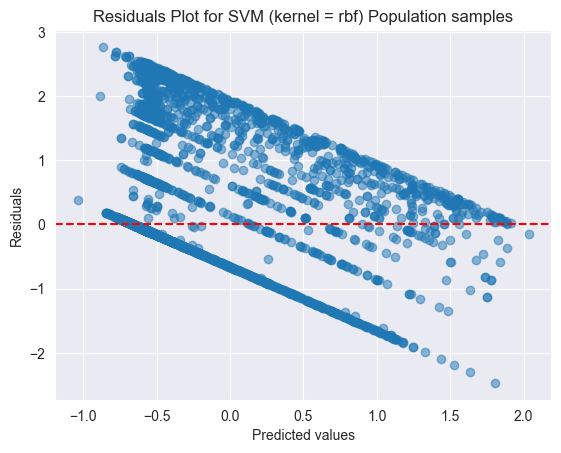

In [150]:
test_model(model_svr_population, data_population["X_test"], data_population["y_test"], "SVM (kernel = rbf) Population samples")

R2 score for SVM (kernel = rbf) Colony samples: 0.5285060377628872
MAE score for SVM (kernel = rbf) Colony samples: 0.5150337509143165


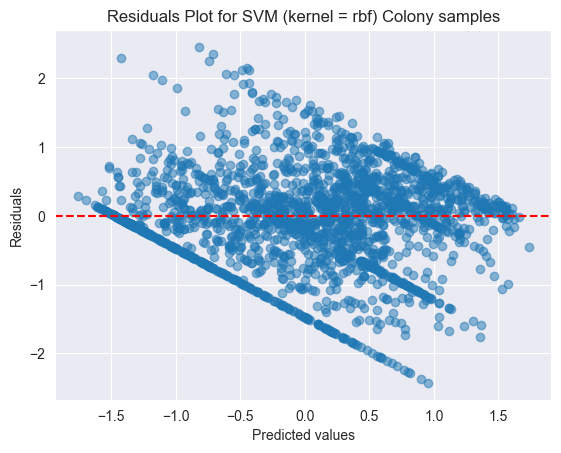

In [151]:
test_model(model_svr_colony, data_colony["X_test"], data_colony["y_test"], "SVM (kernel = rbf) Colony samples")

#### 6.2.2 Polynomial Kernel (degree 2)



In [152]:
model_svr_population = SVR(kernel="poly", degree=2, shrinking=True, tol=0.001)
model_svr_colony = SVR(kernel="poly", degree=2, shrinking=True, tol=0.001)

model_svr_population.fit(data_population["X_train"], data_population["y_train"])
model_svr_colony.fit(data_colony["X_train"], data_colony["y_train"])

SVR(degree=2, kernel='poly')

R2 score for SVM (kernel = poly, degree 2) Population samples: 0.048455644126328745
MAE score for SVM (kernel = poly, degree 2) Population samples: 0.6110398282709496


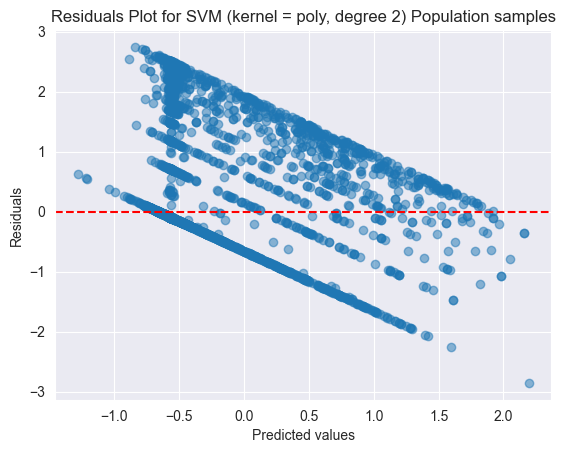

In [153]:
test_model(model_svr_population, data_population["X_test"], data_population["y_test"], "SVM (kernel = poly, degree 2) Population samples")

R2 score for SMV (kernel = poly, degree 2) Colony samples: 0.44878324717385776
MAE score for SMV (kernel = poly, degree 2) Colony samples: 0.5718678743434942


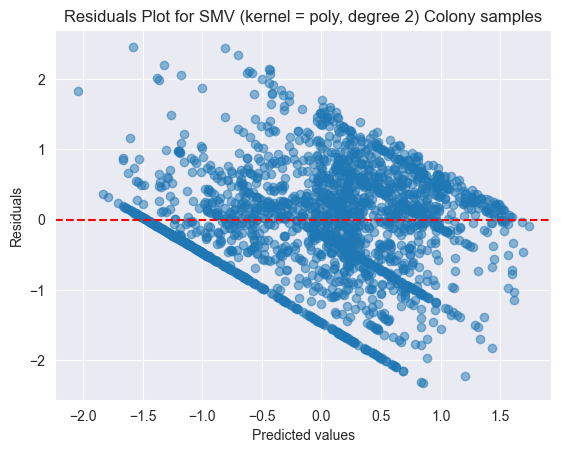

In [154]:
test_model(model_svr_colony, data_colony["X_test"], data_colony["y_test"], "SMV (kernel = poly, degree 2) Colony samples")

#### 6.2.3 Polynomial Kernel (degree 3)

In [155]:
model_svr_population = SVR(kernel="poly", degree=3, shrinking=True, tol=0.001)
model_svr_colony = SVR(kernel="poly", degree=3, shrinking=True, tol=0.001)

model_svr_population.fit(data_population["X_train"], data_population["y_train"])
model_svr_colony.fit(data_colony["X_train"], data_colony["y_train"])

SVR(kernel='poly')

R2 score for SVM (kernel = poly, degree = 3) Population samples: 0.11684206756116466
MAE score for SVM (kernel = poly, degree = 3) Population samples: 0.5882721392653859


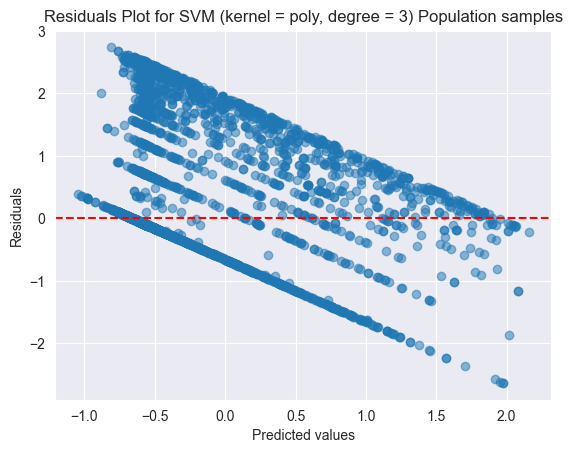

In [156]:
test_model(model_svr_population, data_population["X_test"], data_population["y_test"], "SVM (kernel = poly, degree = 3) Population samples")

R2 score for SVM (kernel = poly, degree = 3) Colony samples: 0.49653499098938725
MAE score for SVM (kernel = poly, degree = 3) Colony samples: 0.535431043339265


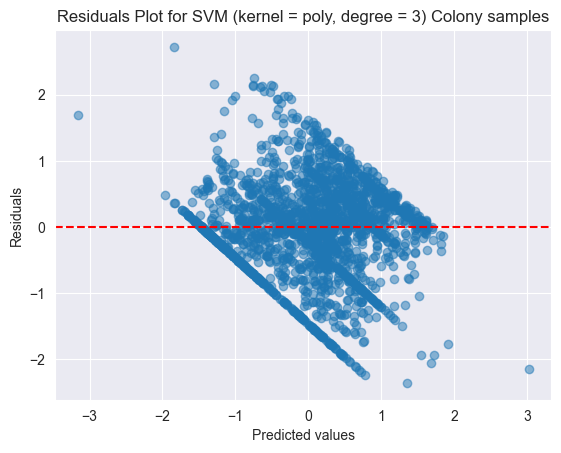

In [157]:
test_model(model_svr_colony, data_colony["X_test"], data_colony["y_test"], "SVM (kernel = poly, degree = 3) Colony samples")

### 6.3 SVM Results Comparison

 SVMs showed persistent scalability limitations when applied to our dataset. Training non-linear kernels was computationally expensive, making large-scale tuning impractical.

Additionally, SVMs are sensitive to multicollinearity, which can distort the margin geometry and lead to unstable predictions. For this reason, only some experiments were selected for SVMs.




## 7. Ensemble Tree Models

A feature importance analysis was conducted using a Decision Tree Regressor to quantify the contribution of each predictor to the model’s performance. Importance scores were aggregated at the base-feature level to account for one-hot encoded categorical variables, and features exceeding a predefined importance threshold were selected as the most influential predictors


In [158]:
def get_base_feature(feature_name):
    for col in list(num_cols) + list(cat_cols):
        # Handles one-hot encoded names like Country_Name_Australia
        if feature_name == col or feature_name.startswith(col + "_"):
            return col
    return feature_name  # fallback


def tree_feature_importance(X, y, processed_feature_names, threshold=0.01, model=None):

    # If no tree based model is provided, train a default Decision Tree regressor
    if model is None:
        model = DecisionTreeRegressor()
        model.fit(X, y)


    importance = model.feature_importances_

    # Create a DataFrame pairing each processed feature with its importance score and sort by
    importance_df = pd.DataFrame({
        "feature": processed_feature_names,
        "importance": importance
    }).sort_values("importance", ascending=False)

    # Map each processed (possibly one-hot encoded) feature back to its base feature
    importance_df["base_feature"] = importance_df["feature"].apply(get_base_feature)

    # Aggregate importance scores by base feature
    # This sums contributions from all one-hot encoded levels of categorical variables
    grouped_importance = (
        importance_df
        .groupby("base_feature")["importance"]
        .sum()
        .sort_values(ascending=False)
    )

    # Select base features whose aggregated importance exceeds the given threshold
    selected_features_tree = [
        f for f, s in zip(grouped_importance.index, grouped_importance.values)
        if s > threshold
    ]

    # Print selected features and full aggregated importance table for inspection
    print(f"Selected features for trees: {selected_features_tree}")
    print(grouped_importance)

    # Append the target variable so the returned dataset remains model-ready
    selected_features_tree.append(target_value_col)

    return selected_features_tree


In [159]:
selected_features_tree_population = tree_feature_importance(data_population["X_processed"], data_population["y"], data_population["feature_names"])
selected_features_tree_colony = tree_feature_importance(data_colony["X_processed"], data_colony["y"], data_colony["feature_names"])

Selected features for trees: ['TSA', 'SSTA', 'ClimSST', 'Distance_to_Shore', 'Depth_m', 'Country_Name', 'Cyclone_Frequency', 'Temperature_Mean', 'Turbidity', 'Realm_Name', 'Exposure']
base_feature
TSA                    0.158552
SSTA                   0.120129
ClimSST                0.117264
Distance_to_Shore      0.110342
Depth_m                0.108725
Country_Name           0.104217
Cyclone_Frequency      0.082209
Temperature_Mean       0.081551
Turbidity              0.064961
Realm_Name             0.033180
Exposure               0.016848
Ocean_Name             0.002023
Temperature_Maximum    0.000000
Name: importance, dtype: float64
Selected features for trees: ['TSA', 'Country_Name', 'Temperature_Mean', 'Cyclone_Frequency', 'ClimSST', 'Distance_to_Shore', 'Depth_m', 'SSTA', 'Turbidity', 'Ocean_Name', 'Exposure', 'Realm_Name']
base_feature
TSA                    0.154728
Country_Name           0.147191
Temperature_Mean       0.130512
Cyclone_Frequency      0.103725
ClimSST        

### 7.1 Model Selection

Random Forest and XGBoost were selected as advanced ensemble learning methods to evaluate their capacity to model complex, non-linear relationships within the dataset. Both methods provide robust predictive performance, strong generalization, and built-in mechanisms to handle feature interactions, making them well-suited for heterogeneous environmental datasets. Their ability to capture non-linear patterns without extensive feature engineering motivated their use after simpler baseline models demonstrated limited effectiveness.




### 7.2 Initial Ensemble Training

In [160]:
tree_data_population = get_preprocessed_split_data(df_normalized_population[selected_features_tree_population])
tree_data_colony = get_preprocessed_split_data(df_normalized_colony[selected_features_tree_colony])

In [161]:
xgb_model_population = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.3,
    min_child_weight=1,
    gamma=0, # No need to add penalty since there is enough samples
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
)
xgb_model_colony = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.3,
    min_child_weight=1,
    gamma=0, # No need to add penalty since there is enough samples
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
)


xgb_model_population.fit(tree_data_population["X_train"], tree_data_population["y_train"])
xgb_model_colony.fit(tree_data_colony["X_train"], tree_data_colony["y_train"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

R2 score for XGBoost Population samples: 0.80638143774194
MAE score for XGBoost Population samples: 0.154252971618861


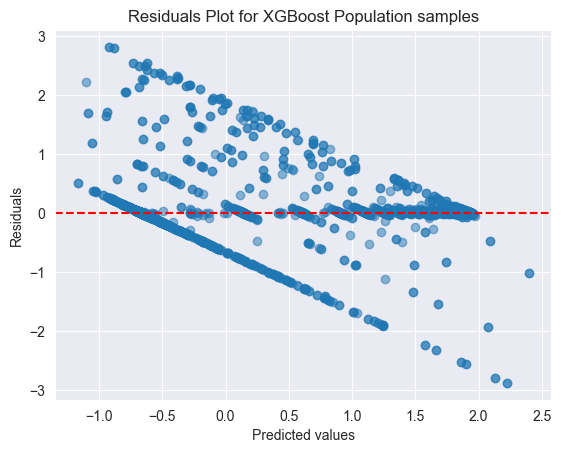

In [162]:
test_model(xgb_model_population, tree_data_population["X_test"], tree_data_population["y_test"], "XGBoost Population samples")

R2 score for XGBoost Colony samples: 0.6559618638751818
MAE score for XGBoost Colony samples: 0.39611304664989194


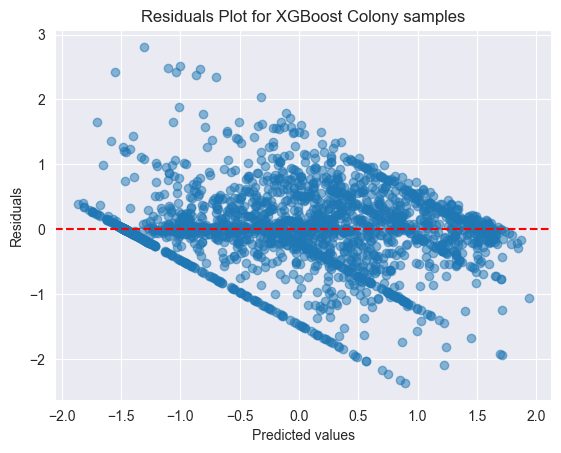

In [163]:
test_model(xgb_model_colony, tree_data_colony["X_test"], tree_data_colony["y_test"], "XGBoost Colony samples")

In [164]:
rf_model_population = RandomForestRegressor(
    n_estimators=600,
    max_depth=30,
    criterion="friedman_mse",
    max_features=0.5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.,
    bootstrap=False,
    random_state=42,
    n_jobs=-1)

rf_model_colony = RandomForestRegressor(
    n_estimators=600,
    max_depth=30,
    criterion="friedman_mse",
    max_features=0.5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.,
    bootstrap=False,
    random_state=42,
    n_jobs=-1)

rf_model_population.fit(tree_data_population["X_train"], tree_data_population["y_train"])
rf_model_colony.fit(tree_data_colony["X_train"], tree_data_colony["y_train"])

RandomForestRegressor(bootstrap=False, criterion='friedman_mse', max_depth=30,
                      max_features=0.5, n_estimators=600, n_jobs=-1,
                      random_state=42)

R2 score for Randon Forest Population samples: 0.8325900179684919
MAE score for Randon Forest Population samples: 0.1387712982685741


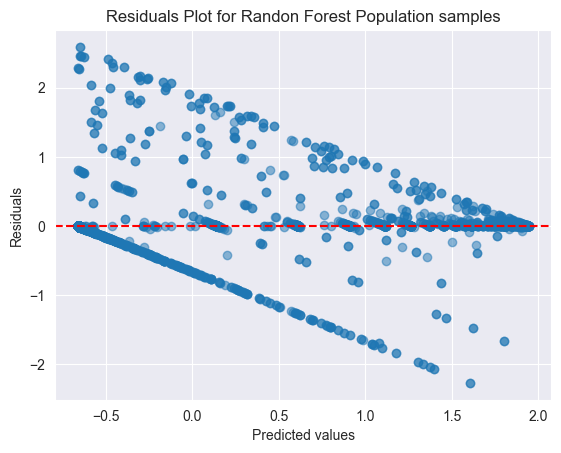

In [165]:
test_model(rf_model_population, tree_data_population["X_test"], tree_data_population["y_test"], "Randon Forest Population samples")

R2 score for Randon Forest Population samples: 0.6963347435785712
MAE score for Randon Forest Population samples: 0.3596326935484114


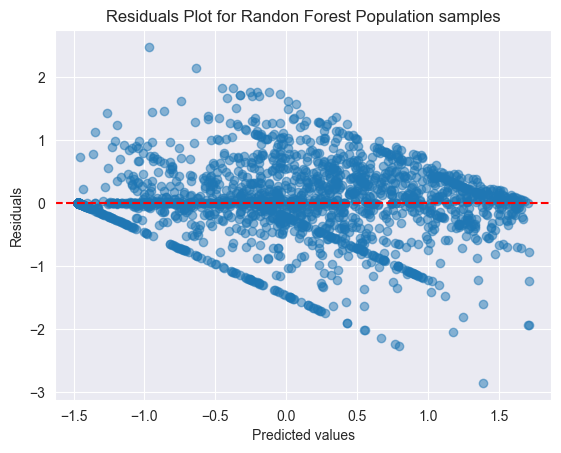

In [166]:
test_model(rf_model_colony, tree_data_colony["X_test"], tree_data_colony["y_test"], "Randon Forest Population samples")

### 7.4 Hyperparameter Refinement

Further feature refinement was not performed, as the selected feature set already demonstrated strong performance.

In [167]:
refined_features_tree_population = tree_feature_importance(tree_data_population["X_processed"], tree_data_population["y"], tree_data_population["feature_names"], threshold=0.02, model=rf_model_population)

refined_features_tree_colony = tree_feature_importance(tree_data_colony["X_processed"], tree_data_colony["y"], tree_data_colony["feature_names"], threshold=0.02, model=rf_model_colony)

refined_tree_data_population = get_preprocessed_split_data(df_normalized_population[refined_features_tree_population])
refined_tree_data_colony = get_preprocessed_split_data(df_normalized_colony[refined_features_tree_colony])

Selected features for trees: ['TSA', 'SSTA', 'ClimSST', 'Depth_m', 'Distance_to_Shore', 'Country_Name', 'Temperature_Mean', 'Cyclone_Frequency', 'Turbidity', 'Realm_Name']
base_feature
TSA                  0.143891
SSTA                 0.127626
ClimSST              0.118742
Depth_m              0.111095
Distance_to_Shore    0.110314
Country_Name         0.100966
Temperature_Mean     0.091228
Cyclone_Frequency    0.077112
Turbidity            0.071907
Realm_Name           0.029594
Exposure             0.017526
Name: importance, dtype: float64
Selected features for trees: ['TSA', 'Country_Name', 'Temperature_Mean', 'ClimSST', 'Depth_m', 'Cyclone_Frequency', 'Distance_to_Shore', 'SSTA', 'Turbidity', 'Realm_Name', 'Ocean_Name']
base_feature
TSA                  0.156557
Country_Name         0.136340
Temperature_Mean     0.128123
ClimSST              0.098635
Depth_m              0.096426
Cyclone_Frequency    0.084970
Distance_to_Shore    0.084545
SSTA                 0.082153
Turbidity    

In [168]:
refined_xgb_model_population = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.3,
    min_child_weight=1,
    gamma=0,  # No need to add penalty since there is enough samples
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
)
refined_xgb_model_colony = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.3,
    min_child_weight=1,
    gamma=0,  # No need to add penalty since there is enough samples
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
)

refined_xgb_model_population.fit(refined_tree_data_population["X_train"], refined_tree_data_population["y_train"])
refined_xgb_model_colony.fit(refined_tree_data_colony["X_train"], refined_tree_data_colony["y_train"])


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

R2 score for Refined XGBoost Population samples: 0.8023479072781903
MAE score for Refined XGBoost Population samples: 0.15806360112599036


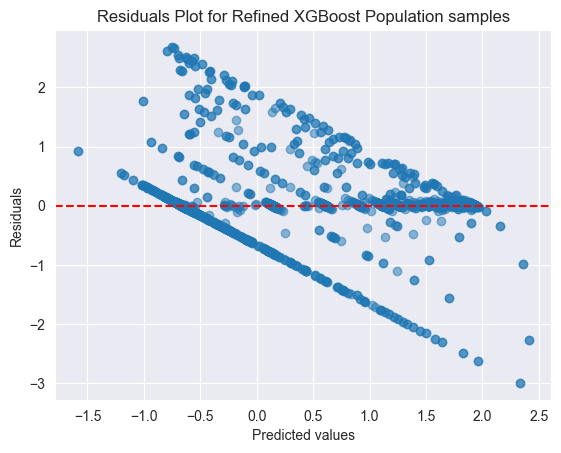

In [169]:
test_model(refined_xgb_model_population, refined_tree_data_population["X_test"], refined_tree_data_population["y_test"], "Refined XGBoost Population samples")

R2 score for Refined XGBoost Colony samples: 0.6528223680742902
MAE score for Refined XGBoost Colony samples: 0.39323448974159225


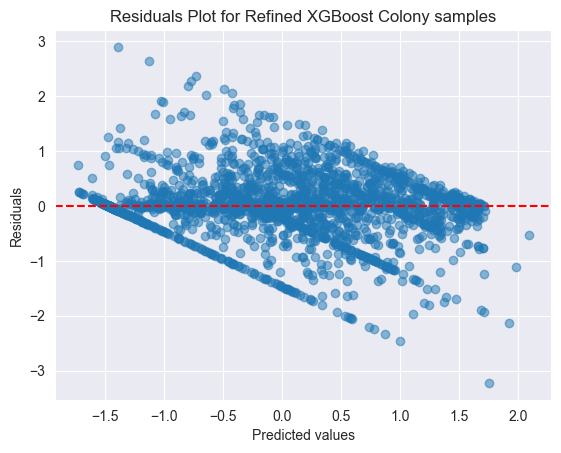

In [170]:
test_model(refined_xgb_model_colony, refined_tree_data_colony["X_test"], refined_tree_data_colony["y_test"], "Refined XGBoost Colony samples")

In [171]:
refined_rf_model_population = RandomForestRegressor(
    n_estimators=600,
    max_depth=30,
    criterion="friedman_mse",
    max_features=0.5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.,
    bootstrap=False,
    random_state=42,
    n_jobs=-1)

refined_rf_model_colony = RandomForestRegressor(
    n_estimators=600,
    max_depth=30,
    criterion="friedman_mse",
    max_features=0.5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.,
    bootstrap=False,
    random_state=42,
    n_jobs=-1)

refined_rf_model_population.fit(refined_tree_data_population["X_train"], refined_tree_data_population["y_train"])
refined_rf_model_colony.fit(refined_tree_data_colony["X_train"], refined_tree_data_colony["y_train"])

RandomForestRegressor(bootstrap=False, criterion='friedman_mse', max_depth=30,
                      max_features=0.5, n_estimators=600, n_jobs=-1,
                      random_state=42)

R2 score for Refined Randon Forest Population samples: 0.8334254312549976
MAE score for Refined Randon Forest Population samples: 0.13752332480881344


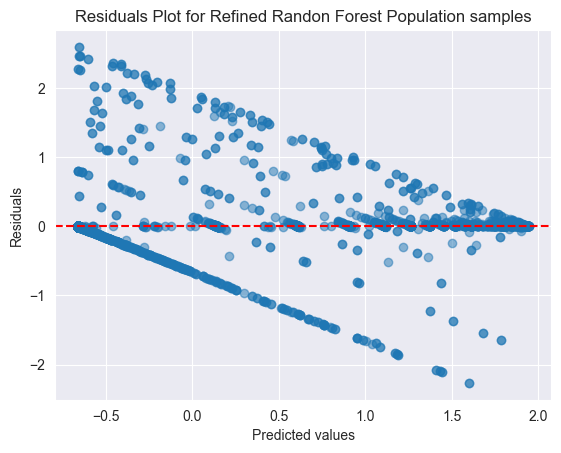

In [172]:
test_model(refined_rf_model_population, refined_tree_data_population["X_test"], refined_tree_data_population["y_test"], "Refined Randon Forest Population samples")

R2 score for Refined Randon Forest Population samples: 0.6965889738752673
MAE score for Refined Randon Forest Population samples: 0.35907929307846015


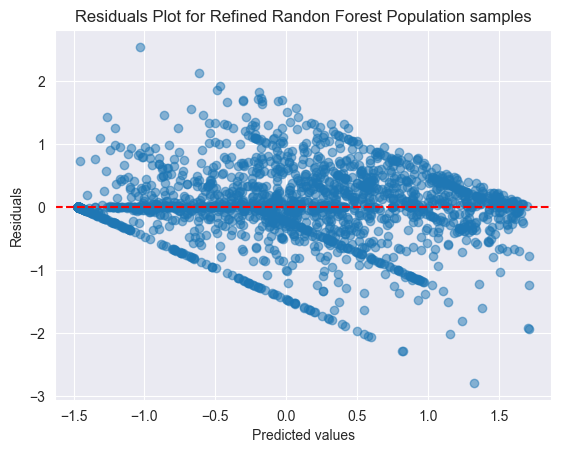

In [173]:
test_model(refined_rf_model_colony, refined_tree_data_colony["X_test"], refined_tree_data_colony["y_test"], "Refined Randon Forest Population samples")

### 7.5 Ensemble Results

Random Forest demonstrated the most robust performance, achieving the lowest MAE and stable R2, especially in the presence of numerous high-bleaching outliers. Its architecture of aggregated decision trees made it less sensitive to noise and better able to approximate the real distribution of extreme bleaching values.
	XGBoost delivered similarly strong results and showed superior performance within the main cluster of bleaching values. It benefited more from feature engineering than Random Forest, improving significantly after removing weak or correlated predictors. However, XGBoost tended to make fewer but larger errors, making it slightly less reliable in the outlier-heavy tail of the target distribution.


## 8. Deep Neural Networks (DNN)

### 8.1 Motivation for Deep Neural Networks (DNN)

* **Handle non-linear relationships:** DNNs can model complex, non-linear dependencies between environmental and geographic variables.
* **Leverage high-dimensional interactions:** While DNNs can learn interactions automatically, explicit feature engineering (threshold-based, interaction, and group-wise features) improves their ability to capture key ecological patterns.

### 8.2 Feature engineering for DNN

These engineered features capture the joint effect of two variables on coral bleaching that might not be captured.

In [174]:
dnn_df_population = df_population.copy()
dnn_df_colony = df_colony.copy()


dnn_df_colony.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10295 entries, 0 to 35044
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cyclone_Frequency    10295 non-null  float64
 1   Depth_m              10295 non-null  float64
 2   ClimSST              10295 non-null  float64
 3   Ocean_Name           10295 non-null  object 
 4   Country_Name         10295 non-null  object 
 5   Distance_to_Shore    10295 non-null  float64
 6   Exposure             10295 non-null  object 
 7   Turbidity            10295 non-null  float64
 8   Temperature_Maximum  10295 non-null  float64
 9   SSTA                 10295 non-null  float64
 10  TSA                  10295 non-null  float64
 11  Percent_Bleaching    10295 non-null  float64
 12  Temperature_Mean     10295 non-null  float64
 13  Realm_Name           10295 non-null  object 
dtypes: float64(10), object(4)
memory usage: 1.2+ MB


**Interaction Feature Engineering**

To capture potential nonlinear relationships between predictors, pairwise interaction features were generated by multiplying selected combinations of variables. Interaction terms were created only when both constituent features were present in the dataset, ensuring robustness across different data subsets. This approach enables the model to account for joint effects that may not be captured by individual features alone.

In [175]:
def create_interaction_features(df, interactions):

    df_copy = df.copy()

    # Loop over each specified pair of features
    for a, b in interactions:

        # Ensure both features exist in the DataFrame
        if a in df_copy.columns and b in df_copy.columns:
            # Create an interaction feature by multiplying the two columns
            df_copy[f"{a}_x_{b}"] = df_copy[a] * df_copy[b]

    # Return the DataFrame with added interaction features
    return df_copy

In [176]:
interactions = [
    # Thermal stress vs physical conditions
    ("TSA", "Depth_m"),             # Shallow reefs may bleach more under thermal stress
    ("TSA", "Distance_to_Shore"),   # Coastal reefs may respond differently to thermal anomalies

    # Water clarity & stress
    ("Turbidity", "Temperature_Mean"), # Murky water + high temps reduce photosynthesis
    ("Turbidity", "Distance_to_Shore"),# Turbidity often higher nearshore


    # Cyclones / physical disturbance
    ("Cyclone_Frequency", "Depth_m"),           # Shallow reefs more impacted by storms
    ("Cyclone_Frequency", "Temperature_Mean"),  # Heat stress + cyclone damage interaction
    ("Cyclone_Frequency", "Distance_to_Shore"), # Coastal and open ocean effects

    # Geographical conditions
    ("Depth_m", "Distance_to_Shore"),   # Coastal shallow reefs behave differently
]

dnn_df_interaction_population = create_interaction_features(dnn_df_population, interactions)
dnn_df_interaction_colony = create_interaction_features(dnn_df_colony, interactions)


**Group-Based Feature Normalization and Category Consolidation**

Group-based normalization was applied to selected numerical variables to account for systematic differences across categorical groupings. For each specified feature, values were standardized within groups defined by a reference categorical variable using z-score normalization, computed relative to the group mean and standard deviation. To prevent numerical instability, a small constant was added to the denominator.

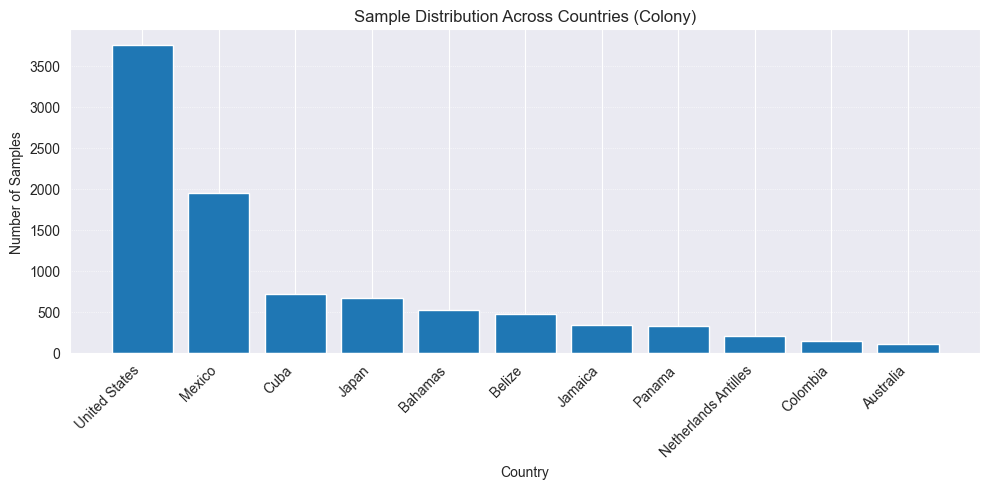

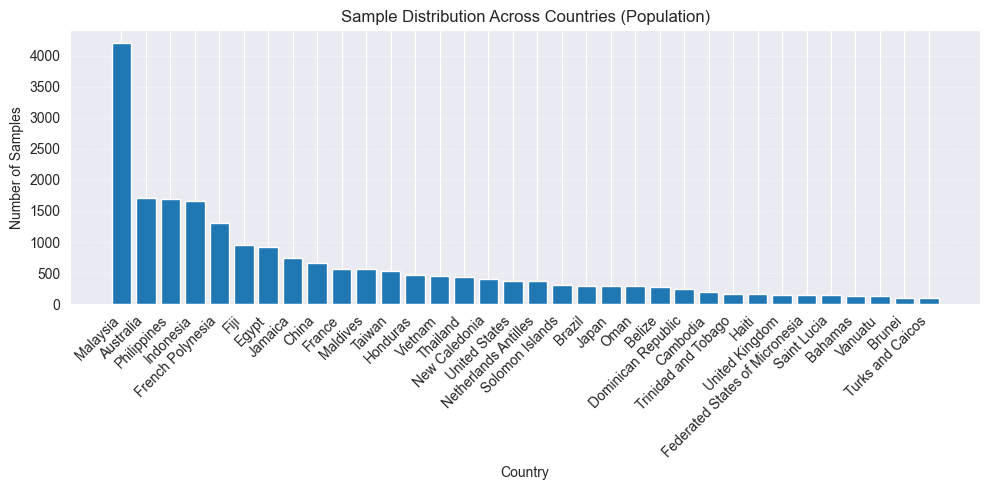

In [177]:
def plot_country_distribution(df, title, min_n=100):
    country_count = df["Country_Name"].value_counts()
    country_count = country_count[country_count >= min_n]

    plt.figure(figsize=(10, 5))
    plt.bar(country_count.index, country_count.values)
    plt.xlabel("Country")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle=":", linewidth=0.5)
    plt.tight_layout()
    plt.show()


plot_country_distribution(dnn_df_colony, "Sample Distribution Across Countries (Colony)")
plot_country_distribution(dnn_df_population, "Sample Distribution Across Countries (Population)")


In [178]:
def group_normalize(df, value_cols, group_col):

    if target_value_col in value_cols:
        value_cols.remove(target_value_col)


    df_copy = df.copy()

    # Apply group-wise z-score normalization for each specified numerical column
    for col in value_cols:
        df_copy[f"{col}_grp_z"] = (
            df_copy[col] -
            df_copy.groupby(group_col)[col].transform("mean")   # Subtract group mean
        ) / (
            df_copy.groupby(group_col)[col].transform("std") + 1e-6 # Divide by group std
        )

    return df_copy


In [179]:
def add_valid_groups(df, min_n=100):
    # Create a copy of the DataFrame to avoid modifying the original data
    df_copy = df.copy()

    # Identify countries with at least min_n observations
    valid_countries = (
        df_copy["Country_Name"]
        .value_counts()             # Count observations per country
        .loc[lambda x: x >= min_n]  # Keep only sufficiently frequent countries
        .index
    )

    # Assign infrequent countries to a common 'Other' category
    df_copy["Country_group"] = df_copy["Country_Name"].where(
        df_copy["Country_Name"].isin(valid_countries),
        "Other"
    )

    # Identify exposure categories with at least min_n observations
    valid_exposure = (
        df_copy["Exposure"]
        .value_counts()
        .loc[lambda x: x >= min_n]  # Keep only sufficiently frequent categories
        .index
    )

    # Assign infrequent exposure categories to a common 'Other' category
    df_copy["Exposure_group"] = df_copy["Exposure"].where(
        df_copy["Exposure"].isin(valid_exposure),
        "Other"
    )

    # Return the DataFrame with consolidated categorical groupings
    return df_copy


In [180]:
# # Select numeric columns (exclude target)

dnn_df_groups_population = add_valid_groups(dnn_df_interaction_population, min_n=50)
dnn_df_groups_colony = add_valid_groups(dnn_df_interaction_colony)

dnn_num_cols_population = (
    dnn_df_groups_population
    .select_dtypes(include=[np.number])
    .columns
    .drop("Percent_Bleaching")
    .tolist()
)

dnn_num_cols_colony = (
    dnn_df_groups_colony
    .select_dtypes(include=[np.number])
    .columns
    .drop("Percent_Bleaching")
    .tolist()
)

dnn_df_groups_population = group_normalize(dnn_df_groups_population, value_cols=dnn_num_cols_population, group_col="Country_group")
dnn_df_groups_population = group_normalize(dnn_df_groups_population, value_cols=dnn_num_cols_population, group_col="Exposure_group")


dnn_df_groups_colony = group_normalize(dnn_df_groups_colony, value_cols=dnn_num_cols_colony, group_col="Country_group")
dnn_df_groups_colony = group_normalize(dnn_df_groups_colony, value_cols=dnn_num_cols_colony, group_col="Exposure_group")


dnn_df_groups_colony.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10295 entries, 0 to 35044
Data columns (total 41 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Cyclone_Frequency                            10295 non-null  float64
 1   Depth_m                                      10295 non-null  float64
 2   ClimSST                                      10295 non-null  float64
 3   Ocean_Name                                   10295 non-null  object 
 4   Country_Name                                 10295 non-null  object 
 5   Distance_to_Shore                            10295 non-null  float64
 6   Exposure                                     10295 non-null  object 
 7   Turbidity                                    10295 non-null  float64
 8   Temperature_Maximum                          10295 non-null  float64
 9   SSTA                                         10295 non-null  float64
 10  TSA

In [181]:
# Compute skewness
dnn_skewness_population = get_skewness(dnn_df_groups_population)
dnn_skewness_colony = get_skewness(dnn_df_groups_colony)

# Normalize data
dnn_df_normalized_population = normalize_df(
    dnn_df_groups_population, dnn_skewness_population
)

dnn_df_normalized_colony = normalize_df(
    dnn_df_groups_colony, dnn_skewness_colony
)

dnn_df_normalized_colony.info()

                                             skewness                skew_type
Cyclone_Frequency_x_Distance_to_Shore         9.71311         Right (Positive)
TSA_x_Distance_to_Shore                     -9.577349          Left (Negative)
TSA_x_Distance_to_Shore_grp_z               -8.771947          Left (Negative)
Depth_m_x_Distance_to_Shore                  8.518925         Right (Positive)
Cyclone_Frequency_x_Distance_to_Shore_grp_z  8.450558         Right (Positive)
Distance_to_Shore                            8.244481         Right (Positive)
Distance_to_Shore_grp_z                       8.09179         Right (Positive)
Depth_m_x_Distance_to_Shore_grp_z             6.74042         Right (Positive)
Turbidity_x_Distance_to_Shore                6.102161         Right (Positive)
Percent_Bleaching                            6.034016         Right (Positive)
Turbidity_x_Distance_to_Shore_grp_z          5.615773         Right (Positive)
Turbidity_x_Temperature_Mean                 3.65283

C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Left-skewed: ['ClimSST', 'TSA', 'Temperature_Mean', 'TSA_x_Depth_m', 'TSA_x_Distance_to_Shore', 'ClimSST_grp_z', 'TSA_grp_z', 'Temperature_Mean_grp_z', 'TSA_x_Depth_m_grp_z', 'TSA_x_Distance_to_Shore_grp_z']
Right-skewed: ['Depth_m', 'Distance_to_Shore', 'Turbidity', 'Temperature_Maximum', 'Percent_Bleaching', 'Turbidity_x_Temperature_Mean', 'Turbidity_x_Distance_to_Shore', 'Cyclone_Frequency_x_Depth_m', 'Cyclone_Frequency_x_Distance_to_Shore', 'Depth_m_x_Distance_to_Shore', 'Cyclone_Frequency_grp_z', 'Depth_m_grp_z', 'Distance_to_Shore_grp_z', 'Turbidity_grp_z', 'Temperature_Maximum_grp_z', 'Turbidity_x_Temperature_Mean_grp_z', 'Turbidity_x_Distance_to_Shore_grp_z', 'Cyclone_Frequency_x_Depth_m_grp_z', 'Cyclone_Frequency_x_Temperature_Mean_grp_z', 'Cyclone_Frequency_x_Distance_to_Shore_grp_z', 'Depth_m_x_Distance_to_Shore_grp_z']
<class 'pandas.core.frame.DataFrame'>
Index: 10295 entries, 0 to 35044
Data columns (total 41 columns):
 #   Column                                       Non

C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [182]:

dnn_data_population = get_preprocessed_split_data(dnn_df_normalized_population)
dnn_data_colony = get_preprocessed_split_data(dnn_df_normalized_colony)

### 8.3 Architecture Design

The neural network uses two fully connected hidden layers with ReLU activation to model nonlinear relationships while maintaining moderate complexity. The number of hidden units was set using a two-thirds-of-input heuristic, which served as the baseline architecture. We evaluated alternative designs by varying network depth (2 vs. 3 layers), width (70 vs. 128 units), dropout placement, and learning rate.

Results show that increasing capacity beyond the baseline produced target-dependent gains. For the colony task, wider (128–128) and deeper (128–64–32) architectures achieved lower MAE than the baseline, indicating benefits from additional capacity in modelling more heterogeneous patterns. In contrast, for the population task, the baseline architecture achieved the best generalisation, with deeper and wider models exhibiting higher error and reduced R², suggesting mild overfitting. Hidden-layer dropout consistently degraded performance across both targets, while moderate learning rates (≈0.002) converged most reliably.

Overall, the baseline two-layer architecture provided the most consistent performance across both tasks, offering a robust balance between capacity and generalisation on skewed, high-dimensional data, and was therefore selected as the final model.

In [80]:
def get_dnn(X):

    nodes_number = int((X.shape[1] + 1) * 2/3)

    model = Sequential()
    model.add(Input(shape = (X.shape[1],)))
    model.add(Dense(nodes_number, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(nodes_number, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    return model


In [81]:
model_dnn_population = get_dnn(dnn_data_population["X_train"])

model_dnn_colony = get_dnn(dnn_data_colony["X_train"])

model_dnn_population.summary()
model_dnn_colony.summary()

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_166 (Dense)               │ (None, 116)            │        20,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 116)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 116)            │        13,572 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 116)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 1)              │           117 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,873 (132.32 KB)

 Trainable params: 33,873 (132.32 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_169 (Dense)               │ (None, 81)             │         9,882 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 81)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 81)             │         6,642 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 81)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 1)              │            82 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,606 (64.87 KB)

 Trainable params: 16,606 (64.87 KB)

 Non-trainable params: 0 (0.00 B)

### 8.4 Training & Optimization

  Both neural network models were trained using the mean squared error (MSE) loss function, appropriate for continuous regression tasks, and optimized with the Adam optimizer due to its adaptive learning rate and stable convergence properties. Model performance was monitored using mean absolute error (MAE) as an additional evaluation metric. Early stopping was used with patience of eight epochs and restoration of the best-performing weights to prevent overfitting.

In [ ]:

early_stop_population = EarlyStopping(
    patience=8,
    restore_best_weights=True,
    monitor='loss'
)

early_stop_colony = EarlyStopping(
    patience=10,
    restore_best_weights=True,
    monitor='loss'
)

model_dnn_population.compile(optimizer="adam",
              loss="mse",
              metrics=['mae'],
               )

model_dnn_colony.compile(optimizer="adam",
              loss="mse",
              metrics=['mae'])

In [83]:
model_dnn_population.fit(dnn_data_population["X_train"], dnn_data_population["y_train"], epochs=200, verbose=2, callbacks=[early_stop_population])


Epoch 1/200
561/561 - 1s - 2ms/step - loss: 0.8766 - mae: 0.7713
Epoch 2/200
561/561 - 0s - 767us/step - loss: 0.8077 - mae: 0.7263
Epoch 3/200
561/561 - 0s - 772us/step - loss: 0.7863 - mae: 0.7114
Epoch 4/200
561/561 - 0s - 777us/step - loss: 0.7676 - mae: 0.6971
Epoch 5/200
561/561 - 0s - 836us/step - loss: 0.7489 - mae: 0.6864
Epoch 6/200
561/561 - 0s - 825us/step - loss: 0.7320 - mae: 0.6743
Epoch 7/200
561/561 - 1s - 912us/step - loss: 0.7192 - mae: 0.6665
Epoch 8/200
561/561 - 1s - 909us/step - loss: 0.7085 - mae: 0.6603
Epoch 9/200
561/561 - 1s - 962us/step - loss: 0.6964 - mae: 0.6520
Epoch 10/200
561/561 - 1s - 982us/step - loss: 0.6890 - mae: 0.6466
Epoch 11/200
561/561 - 1s - 981us/step - loss: 0.6753 - mae: 0.6402
Epoch 12/200
561/561 - 1s - 961us/step - loss: 0.6642 - mae: 0.6322
Epoch 13/200
561/561 - 1s - 907us/step - loss: 0.6578 - mae: 0.6260
Epoch 14/200
561/561 - 0s - 879us/step - loss: 0.6476 - mae: 0.6213
Epoch 15/200
561/561 - 0s - 776us/step - loss: 0.6427 - mae

In [84]:
model_dnn_colony.fit(dnn_data_colony["X_train"], dnn_data_colony["y_train"], epochs=200, verbose=2, callbacks=[early_stop_colony])

Epoch 1/200
258/258 - 1s - 2ms/step - loss: 0.7274 - mae: 0.6997
Epoch 2/200
258/258 - 0s - 876us/step - loss: 0.6033 - mae: 0.6275
Epoch 3/200
258/258 - 0s - 779us/step - loss: 0.5653 - mae: 0.6019
Epoch 4/200
258/258 - 0s - 807us/step - loss: 0.5346 - mae: 0.5861
Epoch 5/200
258/258 - 0s - 775us/step - loss: 0.5163 - mae: 0.5750
Epoch 6/200
258/258 - 0s - 760us/step - loss: 0.4963 - mae: 0.5627
Epoch 7/200
258/258 - 0s - 761us/step - loss: 0.4887 - mae: 0.5551
Epoch 8/200
258/258 - 0s - 774us/step - loss: 0.4715 - mae: 0.5453
Epoch 9/200
258/258 - 0s - 800us/step - loss: 0.4694 - mae: 0.5427
Epoch 10/200
258/258 - 0s - 795us/step - loss: 0.4532 - mae: 0.5303
Epoch 11/200
258/258 - 0s - 820us/step - loss: 0.4434 - mae: 0.5256
Epoch 12/200
258/258 - 0s - 853us/step - loss: 0.4487 - mae: 0.5273
Epoch 13/200
258/258 - 0s - 847us/step - loss: 0.4320 - mae: 0.5178
Epoch 14/200
258/258 - 0s - 857us/step - loss: 0.4258 - mae: 0.5116
Epoch 15/200
258/258 - 0s - 865us/step - loss: 0.4211 - mae

### 9.5 DNN Performance


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
R2 score for DNN Population Samples: 0.5279074780089432
MAE score for DNN Population Samples: 0.4713076455471145


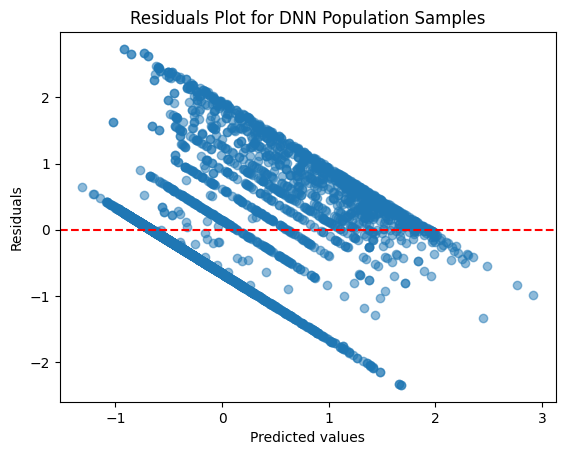

In [86]:
test_model(model_dnn_population, dnn_data_population["X_test"], dnn_data_population["y_test"], "DNN Population Samples")

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
R2 score for DNN Colony Samples: 0.6101965643433864
MAE score for DNN Colony Samples: 0.4631975543206913


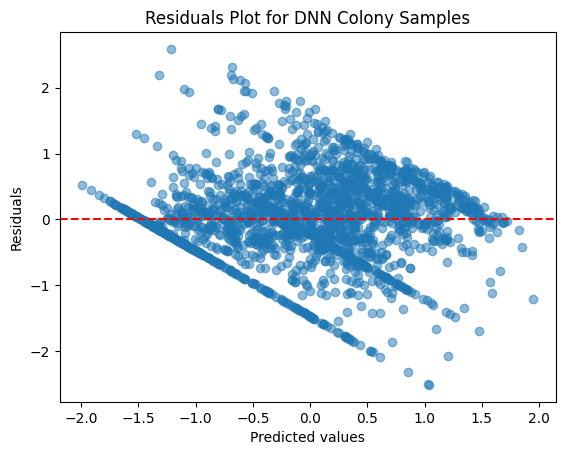

In [87]:
test_model(model_dnn_colony, dnn_data_colony["X_test"], dnn_data_colony["y_test"], "DNN Colony Samples")

## 9. Conclusions

### 9.1. Final Model Selection

- **Selected model**
Ensemble tree-based models (Random Forest and XGBoosting) were selected as the final models.
The dataset exhibits  non-linear relationships, complex interactions between environmental and geographic variables, and pronounced skewness with outliers. Ensemble tree methods handle these characteristics effectively, as they do not rely on distance-based metrics or gradient optimization that can be distorted by extreme values. In contrast, SVMs and deep neural networks showed higher sensitivity to feature scaling, skewness, and extreme observations, resulting in less stable performance.

- **Strengths and weaknesses**
The main strengths of ensemble trees include robustness to outliers, the ability to implicitly capture feature interactions without explicit feature engineering, and consistent generalization across different dataset variants. Their primary limitations are reduced interpretability compared to linear models and higher computational cost relative to simpler approaches, particularly when training large ensembles.

### 9.2. Key Findings

* Causal structure (DAG) for coral bleaching analysis:

```text
   Geography ---> Human Impact ---> Bleaching
        |              |                ∧
        |              ∨                |
        --------> Environment -----------
```

   **Geography** (e.g., distance to shore, ocean, country, depth) affects:
        - Human impact (population, fishing, pollution)
        - Environmental conditions (temperature, turbidity, light, currents)
        - Bleaching directly through natural ecological pathways

   **Human impact** also influences the environment (e.g., pollution, sedimentation), creating indirect effects on bleaching.

   To estimate the causal effect Human Impact -> Bleaching, geographic variables must be included as controls to block backdoor paths.

  * Model Behavior: Support Vector Machines (SVM)

    Support Vector Machines exhibited limited suitability for this task due to significant scalability constraints, with training becoming computationally prohibitive on larger datasets and a hyperparameter tuning was impractical. Model performance was further degraded by sensitivity to multicollinearity, as highly correlated predictors distorted the margin structure and led to unstable predictions. Additionally, the heavily skewed distribution of Percent_Bleaching posed challenges for SVMs, resulting in systematic underestimation of extreme bleaching events. However, the model demonstrated comparatively better performance on the colony-level dataset, where the target distribution was less skewed and the sample structure more homogeneous.


  * Model Behavior: Ensemble Tree Models (Random Forest & XGBoost)
    **Random Forest**

    Random Forest demonstrated stronger performance on the colony-level dataset, which is characterized by sparser observations. By aggregating predictions across many decision trees, the model effectively averages local patterns and is robust to outliers, resulting in more frequent but smaller errors and lower MAE. Its performance remained stable even when weak or correlated features were removed, indicating low sensitivity to feature selection. However, training time increased with high-cardinality categorical variables, though excluding these features substantially improved computational efficiency.

    **XGBoost**

    XGBoost performed better on the population-level dataset, which exhibits a denser and more skewed distribution of bleaching values. The model showed strong predictive accuracy within the dominant data cluster (approximately 0–35% bleaching), highlighting its effectiveness in learning patterns from concentrated clusters of data.XGBoost produced fewer but larger errors, but making extreme bleaching predictions less accurate .It benefited more noticeably from feature selection and the removal of weak or correlated predictors compared to Random Forest.

 * Model Behavior: Deep Neural Network (DNN)

    The Deep Neural Network achieved moderate performance following extensive feature engineering, particularly when interaction features were explicitly constructed to capture relationships between related variables. The model exhibited behavior partly similar to Support Vector Machines, showing sensitivity to feature representation and target distribution. However, unlike SVMs, the DNN did not suffer from scalability limitations, as its optimization in parameter space allowed efficient training on larger datasets.

### 9.3 Limitations

* Imbalanced data: The dataset is highly imbalanced, with a disproportionate number of non-bleaching reefs compared to fewer bleaching and severely bleached observations, which add bias toward majority patterns and makes accurate modeling of extreme bleaching events more challenging.

* Multicollinearity: Temperature-related variables (Temperature_Mean, Temperature_Maximum, ClimSST) and other correlated features exhibit high variance inflation factors (VIFs), potentially destabilizing models that assume independent predictors.

### 9.4 Future Improvements

 * Feature engineering: Some dataset features still exhibit extreme multicollinearity, which could be mitigated through better targeted feature selection, dimensionality reduction, or the construction of orthogonal representations. Space-based models will benefit this.

* More data:
    Scraping the data sources referenced in the dataset documentation to collect additional observations, improving coverage and model generalization for moderate and severe bleached reef.

* Model tuning:
    Exploit the temporal structure of the dataset by transitioning from feedforward DNNs to sequence models such as RNNs or LSTMs to better capture time-dependent bleaching dynamics. Also apply some feature engineering based on tree feature importance and permutations scores.

## 10. Appendix
This is a table showing all the neural network experiments for reference:
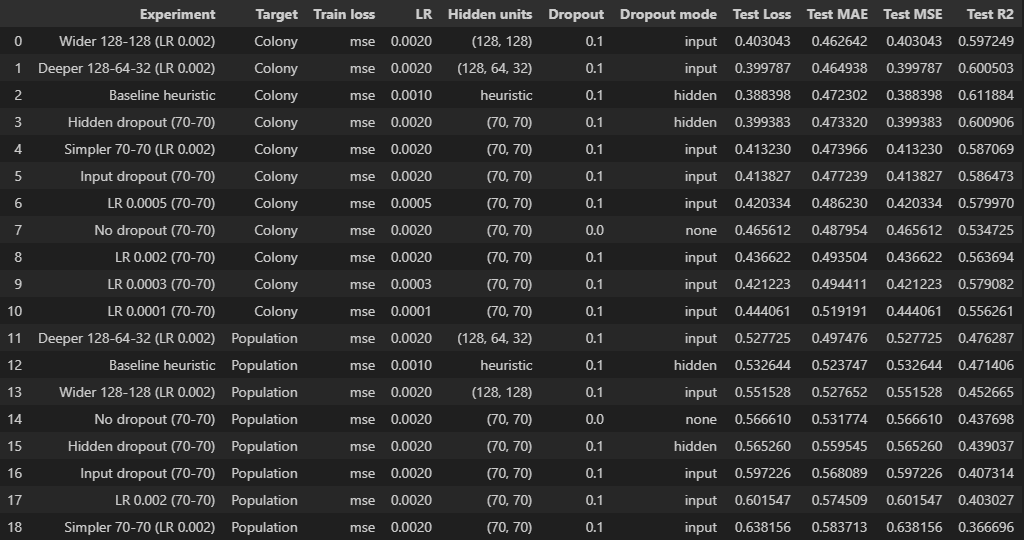


### 10.1 Hyperparameters


### 10.2 Additional Plots

### 10.3 Reproducibility Notes
